Importing necessary libraries

In [1]:
import pandas as pd

from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

import matplotlib.pyplot as plt
plt.style.use('ggplot')
import matplotlib.dates as mdates
import seaborn as sns
import numpy as np
from math import sqrt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import TimeSeriesSplit

import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

Using TensorFlow backend.


Now, we will load our dataset wherein we had filtered outliers in Step 1.

In [2]:
train_df = pd.read_csv('train_outliers_removed.csv')

We need to make the date column as our index. We will also sort the dataframe by index.

In [3]:
train_df['date']=pd.to_datetime(train_df['date'])
train_df.set_index('date', inplace=True)
train_df.sort_index(inplace=True)

We will group our dataset by Commodiy,APMC pairs.
We will predict for only those pairs that have at least 10 months of data. Predicting with lesser
data than that will not make much sense. So, we filter out only those pairs that have more than 10 datapoints.

In [4]:
grouped = train_df.groupby(['Commodity','APMC']).filter(lambda x: len(x) >= 10)

Now that we have only those pairs for which the minimal amount of data exists, we will again group it by
Commodity And APMC.

In [5]:
data = grouped.groupby(['Commodity','APMC'])

We will use LSTM to forecast next 3 month's modal price. 
To do so, let us first get out helper functions set up.

First we need to frame this sequence of modal price values as a supervised learning problem.
This function will create columns and column values will be dataframe values shifted from 1 till lag value.
We will then feed this data as input to network.

In [7]:
def timeseries_to_supervised(data, lag=3):
    df = pd.DataFrame(data)
    columns = [df.shift(i) for i in range(1, lag+1)]
    columns.append(df)
    df = pd.concat(columns, axis=1)
    df.fillna(0, inplace=True)
    return df

This function will create a differenced series with the given interval. This is to remove stationarity.

In [8]:
def difference(dataset, interval=3):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return pd.Series(diff)

This function will invert the differenced value so that we can get the original value at the end.

In [9]:
def inverse_difference(history, yhat, interval=1):
    return yhat + history[-interval]

We will use this function to scale train and test data in between [-1, 1]

In [10]:
def scale(train, test):

    scaler = MinMaxScaler(feature_range=(-1, 1))
    scaler = scaler.fit(train)
    
    # transform train
    train = train.reshape(train.shape[0], train.shape[1])
    train_scaled = scaler.transform(train)
    
    # transform test
    test = test.reshape(test.shape[0], test.shape[1])
    test_scaled = scaler.transform(test)
    return scaler, train_scaled, test_scaled

This function will be used to invert the scaling for a forecasted value in order to give the output value
in the original scale.

In [11]:
def invert_scale(scaler, X, value):
    new_row = [x for x in X] + [value]
    array = np.array(new_row)
    array = array.reshape(1, len(array))
    inverted = scaler.inverse_transform(array)
    return inverted[0, -1]

This function will first define our LSTM architecture and then fit the LSTM network to training data.

In [12]:
def fit_lstm(train, batch_size, nb_epoch, neurons):
    
    X, y = train[:, 0:-1], train[:, -1]
    X = X.reshape(X.shape[0], 1, X.shape[1])
    
    model = Sequential()
    model.add(LSTM(neurons, batch_input_shape=(batch_size, X.shape[1], X.shape[2]), stateful=True))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')

    for i in range(nb_epoch):
        model.fit(X, y, epochs=1, batch_size=batch_size, verbose=0, shuffle=False)
        model.reset_states()
    return model

We will use this function to make a one-step forecast.

In [13]:
def forecast_lstm(model, batch_size, X):
    X = X.reshape(1, 1, len(X))
    yhat = model.predict(X, batch_size=batch_size, verbose=0)
    return yhat[0,0]

Let us combine the above functions to make a prediction.
We will predict for arvi commodity in Mumbai APMC.

In [14]:
date_price = data.get_group(('arvi','Mumbai'))['modal_price']

In [15]:
def preprocessing(date_price):

    # convert our column to pandas series 
    series = pd.Series(date_price)

    # transform data to be stationary

    raw_values = series.values
    diff_values = difference(raw_values, 3)

    # transform data to be supervised learning

    supervised = timeseries_to_supervised(diff_values, 5)
    supervised_values = supervised.values

    # split data into train and test-sets

    train_size = int(len(supervised_values) * 0.66)
    train, test = supervised_values[0:train_size], supervised_values[train_size:len(supervised_values)]

    # transform the scale of the data

    scaler, train_scaled, test_scaled = scale(train, test)
    
    return scaler,train_scaled, test_scaled,raw_values,supervised_values

In [16]:
def train_mandi(train_scaled,test_scaled,scaler,supervised_values,epochs = 5):

    error_scores = list()

    for r in range(epochs):
    
        lstm_model = fit_lstm(train_scaled, 1, 30, 4)
        predictions = list()
    
        # let's predict for test case
    
        for i in range(len(test_scaled)):
            # make one-step forecast
        
            X, y = test_scaled[i, 0:-1], test_scaled[i, -1]
            yhat = forecast_lstm(lstm_model, 1, X)
            
            # invert scaling
            yhat = invert_scale(scaler, X, yhat)
        
            # invert differencing
            yhat = inverse_difference(raw_values, yhat, len(test_scaled)+3-i)
        
            # store forecast
            predictions.append(yhat)
    
    # report performance
    train_size = int(len(supervised_values) * 0.66)
    
    rmse = sqrt(mean_squared_error(raw_values[train_size:len(supervised_values)], predictions))
    print('%d) Test RMSE: %.3f' % (r+1, rmse))
    error_scores.append(rmse)
    return predictions,lstm_model

In [17]:
def viz_performance(raw_values,predictions,supervised_values):

    # line plot of observed vs predicted
    train_size = int(len(supervised_values) * 0.66)
    plt.figure(figsize=(10, 5))
    plt.plot(raw_values[train_size:len(supervised_values)])
    plt.plot(predictions)
    plt.title('Original data vs predicted data', fontsize=18)
    plt.show()

In [18]:
def forecast(raw_values,lstm_model):

    # last value of our dataset
    f = np.array(raw_values[-5:])

    # sklearn minmaxscaler for converting "f" to range to (-1,1)
    scaler = MinMaxScaler(feature_range=(-1, 1))

    # minmaxscaler fit
    scaler = scaler.fit(f.reshape(-1,1))

    # let's transform
    train = f.reshape(5, 1)
    train_scaled = scaler.transform(train)

    # store prediction
    prediction = []

    # range 3 because we want the prediction for next 3 months.
    for i in range(3):
    
        # predict 
        yhat = forecast_lstm(lstm_model, 1, train_scaled)
    
        # inverse prediction to it's original value
        yhat_inver = scaler.inverse_transform(yhat)
    
        # append to our prediction variable
        prediction.append(yhat_inver)
        
        # update our train_scaled array to have latest prediction as input and remove the oldest one 
        # to accomodate it.
        
        temp_list = []
        temp_list.append(yhat)
        temp_list.extend(train_scaled[0:-1])
        
        train_scaled= np.array([temp_list]).reshape(-1,1)
    
    return prediction

Putting it all together!

1) Test RMSE: 249.958


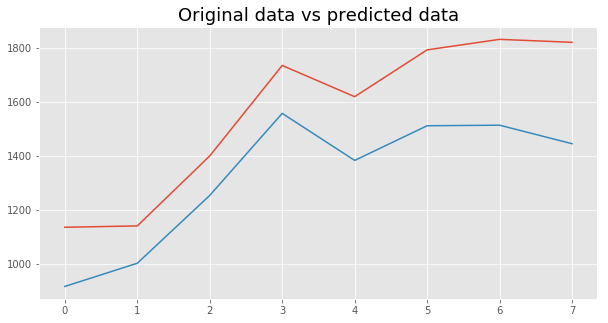

[[ 1665.10339355]]
[[ 1670.77929688]]
[[ 1640.70117188]]


In [19]:
scaler,train_scaled, test_scaled,raw_values,supervised_values = preprocessing(date_price)
predictions, lstm_model = train_mandi(train_scaled,test_scaled,scaler,supervised_values,1)
viz_performance(raw_values,predictions,supervised_values)
predictions = forecast(raw_values,lstm_model)

for pred in predictions:
    print(pred)

Finally, let us make a general function that will just take in the APMC And Commodity name and provide
us with the forecast of next 3 months.

In [22]:
def mandi_forecasting(Commodity,APMC,data):
    
    date_price = data.get_group((Commodity,APMC))['modal_price']
    
    scaler,train_scaled, test_scaled,raw_values,supervised_values = preprocessing(date_price)
    predictions, lstm_model = train_mandi(train_scaled,test_scaled,scaler,supervised_values,1)
    
    viz_performance(raw_values,predictions,supervised_values)
    predictions = forecast(raw_values,lstm_model)

    for pred in predictions:
        print(pred)
    
    return predictions

Let us test this function!

1) Test RMSE: 527.316


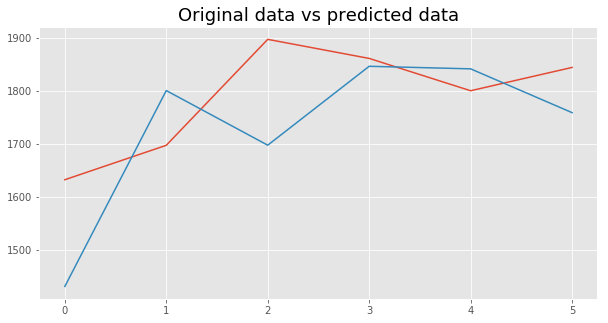

[[ 1616.91308594]]
[[ 1649.78210449]]
[[ 1625.34619141]]


In [23]:
predictions= mandi_forecasting('bajri','Indapur',data)

Perfect. Now we can call this function for all pairs of APMC and Commodities that exist in our data.
(with number of datapoints >10). We can record all their outputs.
This will take quite a lot of time since there a large number of pairs and there will be a seperate model
trained for each!

In [100]:
df = pd.DataFrame(columns=['APMC','Commodity','Month1','Month2','Month3'])

In [103]:
for each_pair in data.groups.keys():
    
    predictions = mandi_forecasting(each_pair[0],each_pair[1],data)
    df = df.append(pd.DataFrame({'APMC':each_pair[1], 'Commodity':each_pair[0],'Month1':predictions[0][0][0],'Month2':predictions[0][0][0],'Month3':predictions[0][0][0]}, index=[0]), ignore_index=True)
    
    

1) Test RMSE: 442.637
1) Test RMSE: 931.886
1) Test RMSE: 886.112
1) Test RMSE: 2860.740
1) Test RMSE: 135.072
1) Test RMSE: 321.506
1) Test RMSE: 519.789
1) Test RMSE: 921.762
1) Test RMSE: 1001.470
1) Test RMSE: 3306.102
1) Test RMSE: 1893.218
1) Test RMSE: 1798.031
1) Test RMSE: 396.965
1) Test RMSE: 681.651
1) Test RMSE: 257.654
1) Test RMSE: 210.223
1) Test RMSE: 599.066
1) Test RMSE: 394.924
1) Test RMSE: 811.510
1) Test RMSE: 1102.635
1) Test RMSE: 873.555
1) Test RMSE: 389.273
1) Test RMSE: 661.329
1) Test RMSE: 856.123
1) Test RMSE: 608.050
1) Test RMSE: 645.235
1) Test RMSE: 989.793
1) Test RMSE: 36.725
1) Test RMSE: 308.968
1) Test RMSE: 306.175
1) Test RMSE: 630.551
1) Test RMSE: 861.960
1) Test RMSE: 486.001
1) Test RMSE: 209.336
1) Test RMSE: 384.559
1) Test RMSE: 71.060
1) Test RMSE: 39.574
1) Test RMSE: 796.406
1) Test RMSE: 572.085
1) Test RMSE: 372.682
1) Test RMSE: 419.093
1) Test RMSE: 406.564
1) Test RMSE: 831.043
1) Test RMSE: 551.076
1) Test RMSE: 686.109
1) Test

1) Test RMSE: 550.212
1) Test RMSE: 358.820
1) Test RMSE: 594.936
1) Test RMSE: 344.674
1) Test RMSE: 524.033
1) Test RMSE: 1464.912
1) Test RMSE: 367.173
1) Test RMSE: 764.952
1) Test RMSE: 467.645
1) Test RMSE: 1027.231
1) Test RMSE: 650.884
1) Test RMSE: 1324.691
1) Test RMSE: 573.503
1) Test RMSE: 808.261
1) Test RMSE: 751.491
1) Test RMSE: 442.699
1) Test RMSE: 946.324
1) Test RMSE: 4349.873
1) Test RMSE: 831.270
1) Test RMSE: 704.841
1) Test RMSE: 1050.330
1) Test RMSE: 950.912
1) Test RMSE: 676.917
1) Test RMSE: 358.399
1) Test RMSE: 247.393
1) Test RMSE: 208.360
1) Test RMSE: 333.831
1) Test RMSE: 964.178
1) Test RMSE: 528.686
1) Test RMSE: 169.800
1) Test RMSE: 148.852
1) Test RMSE: 508.396
1) Test RMSE: 385.356
1) Test RMSE: 657.273
1) Test RMSE: 365.905
1) Test RMSE: 670.627
1) Test RMSE: 842.617
1) Test RMSE: 238.952
1) Test RMSE: 178.436
1) Test RMSE: 283.086
1) Test RMSE: 600.103
1) Test RMSE: 569.631
1) Test RMSE: 333.588
1) Test RMSE: 433.591
1) Test RMSE: 417.082
1) Te

KeyboardInterrupt: 

In [105]:
df

,APMC,Commodity,Month1,Month2,Month3
0,Pune-Manjri,ambat chuka,632.394653,632.394653,632.394653
1,Jalgaon,amla,1661.075317,1661.075317,1661.075317
2,Kamthi,amla,1677.785400,1677.785400,1677.785400
3,Pune-Manjri,ambat chuka,600.604980,600.604980,600.604980
4,Jalgaon,amla,1539.330444,1539.330444,1539.330444
5,Kamthi,amla,1616.770752,1616.770752,1616.770752
6,Amarawati,apple,6405.462891,6405.462891,6405.462891
7,Amarawati-Fruit And Vegetables,apple,6920.278320,6920.278320,6920.278320
8,Aurangabad,apple,7001.582520,7001.582520,7001.582520
9,Chandrapur,apple,5454.176270,5454.176270,5454.176270


I have run this only for first 533 rows ( since it was taking a lot of time). Let us now save this in our output
file.

In [104]:
df.to_csv('output_predictions.csv')

That's it. We can now forecast, for the next 3 months, the prices of each APMC-Commodity pair!